In [531]:
import numpy as np
import os.path
import csv
import pandas
from sklearn import datasets
from sklearn import neighbors
from sklearn import tree
from math import isnan as isnan
from sklearn import preprocessing as pp
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import scale as ppscale
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [335]:
df = pandas.read_csv('train.csv')
dfte = pandas.read_csv('test.csv')

In [336]:
# Some tutorial help to visualize and understand data
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Watson, Mr. Ennis Hastings",male,1601,B96 B98,S
freq,1,577,7,4,644


In [337]:
# survial chance are far greater for females
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [338]:
#extract second sentance in name
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pandas.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [339]:
#combine rare names
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [340]:
# Title from catogrial to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [341]:
#For now, let us also drop cabin, Name, ticket and PassengerId
df=df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [342]:
#converting sex to ordinal
gender_mapping = {"male":0 , "female":1}
df['Sex'] = df['Sex'].map(gender_mapping).astype(int)

In [343]:
#converting embarked, after filling it's two nulls with the most frequent value 'S'
embarked_mapping = {"S":0,"C":1,"Q":2}
df['Embarked'] = df['Embarked'].fillna('S') #filling two bulls in embarked
df['Embarked'] = df['Embarked'].map(embarked_mapping).astype(int)

In [344]:
#All is numerical, left only to deal with the age Nans.
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
dtype: int64

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1
5,0,3,0,NaN,0,0,8.4583,Q,1
6,0,1,0,54.0,0,0,51.8625,S,1
7,0,3,0,2.0,3,1,21.0750,S,4
8,1,3,1,27.0,0,2,11.1333,S,3
9,1,2,1,14.0,1,0,30.0708,C,3


In [34]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

df['isMr'] = df['Title'].isin({1}).astype(int)
df['isMiss'] = df['Title'].isin({2}).astype(int)
df['isMrs'] = df['Title'].isin({3}).astype(int)
df['isMaster'] = df['Title'].isin({4}).astype(int)
df['isRare'] = df['Title'].isin({5}).astype(int)

In [37]:
df=df.drop(['Title'],axis=1)

In [39]:
#using a simple mean age-method
df1 = df.fillna(df.mean())

In [41]:
df1.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
isMr        0
isMiss      0
isMrs       0
isMaster    0
isRare      0
dtype: int64

In [266]:
def train_validate_test_split(arr, train_percent=.6, validate_percent=.3, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(range(len(arr)))
    m = len(arr)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = arr[perm[:train_end]]
    validate = arr[perm[train_end:validate_end]]
    test = arr[perm[validate_end:]]
    return train, validate, test

In [457]:
tr,va, te = train_validate_test_split(df4.as_matrix())

In [458]:
tr_y = tr[:,0]
va_y = va[:,0]
tr_x=tr[:,1:]
va_x=va[:,1:]

In [459]:
random_forest = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,max_depth=5)
random_forest.fit(tr_x,tr_y)
print(random_forest.score(tr_x,tr_y),random_forest.score(va_x,va_y))

0.848314606742 0.835205992509


In [500]:
list(df4)

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'isMr',
 'isMiss',
 'isMrs',
 'isMaster',
 'isRare',
 'Family_size',
 'isAlone']

In [519]:
#best feature-subset selection (runs in exponential time)
from itertools import chain, combinations
from sklearn.cross_validation import cross_val_score

def best_subset_cv(estimator, X, y, cv=5):
    n_features = X.shape[1]
    subsets = chain.from_iterable(combinations(range(n_features), k + 1)
                                  for k in range(n_features))

    best_score = -np.inf
    best_subset = None
    for subset in subsets:
        score = cross_val_score(estimator, X[:, subset], y, cv=cv).mean()
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score

In [524]:
len(list(chain.from_iterable(combinations(range(X.as_matrix().shape[1]), k + 1) for k in range(X.as_matrix().shape[1]))))

16383

In [525]:
df4

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare,Family_size,isAlone
0,0.0,3.0,0.0,22,1.0,0.0,7.250000,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
1,1.0,1.0,1.0,38,1.0,0.0,71.283300,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
2,1.0,3.0,1.0,26,0.0,0.0,7.925000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,35,1.0,0.0,26.550000,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,0.0,3.0,0.0,35,0.0,0.0,8.050000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,3.0,0.0,33,0.0,0.0,8.458300,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,0.0,54,0.0,0.0,51.862500,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,3.0,0.0,2,3.0,1.0,5.268750,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0
8,1.0,3.0,1.0,27,0.0,2.0,3.711100,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
9,1.0,2.0,1.0,14,1.0,0.0,15.035400,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


In [523]:
#Exponential time computation
#X=df4.drop(['Survived'],axis=1)
#Y=df4['Survived']
#random_forest.fit(X,Y)
#best_subset_cv(random_forest,X.as_matrix(),Y.as_matrix())

KeyboardInterrupt: 

In [534]:
ppscale(X)

array([[ 0.82737724, -0.73769513, -0.56018694, ..., -0.16278113,
         0.05915988, -1.2316449 ],
       [-1.56610693,  1.35557354,  0.61164358, ..., -0.16278113,
         0.05915988, -1.2316449 ],
       [ 0.82737724,  1.35557354, -0.26722931, ..., -0.16278113,
        -0.56097483,  0.81192233],
       ..., 
       [ 0.82737724,  1.35557354, -1.51229924, ..., -0.16278113,
         1.29942929, -1.2316449 ],
       [-1.56610693, -0.73769513, -0.26722931, ..., -0.16278113,
        -0.56097483,  0.81192233],
       [ 0.82737724, -0.73769513,  0.17220714, ..., -0.16278113,
        -0.56097483,  0.81192233]])

In [548]:
X=df4.drop(['Survived'],axis=1)
Y=df4['Survived']
random_forest.fit(X,Y)
scores = cross_val_score(random_forest,X,Y,cv=5)
print(scores.mean(),scores.std())

0.827209324676 0.0167370463654


In [544]:
df2=df
guess_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = df2[(df['Sex'] == i) & \
                                (df2['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
for i in range(0, 2):
    for j in range(0, 3):
        df2.loc[ (df2.Age.isnull()) & (df2.Sex == i) & (df2.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

df2['Age'] = df2['Age'].astype(int)

In [94]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare
0,0,3,0,22,1,0,7.2500,0,1,0,0,0,0
1,1,1,1,38,1,0,71.2833,1,0,0,1,0,0
2,1,3,1,26,0,0,7.9250,0,0,1,0,0,0
3,1,1,1,35,1,0,53.1000,0,0,0,1,0,0
4,0,3,0,35,0,0,8.0500,0,1,0,0,0,0
5,0,3,0,25,0,0,8.4583,2,1,0,0,0,0
6,0,1,0,54,0,0,51.8625,0,1,0,0,0,0
7,0,3,0,2,3,1,21.0750,0,0,0,0,1,0
8,1,3,1,27,0,2,11.1333,0,0,0,1,0,0
9,1,2,1,14,1,0,30.0708,1,0,0,1,0,0


In [104]:
df2.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
isMr        0
isMiss      0
isMrs       0
isMaster    0
isRare      0
dtype: int64

In [206]:
#WORKING
df.ix[dfN[dfN.Ticket=='1601'].index,'Fare'] = df.ix[dfN[dfN.Ticket=='1601'].index].Fare *7

74     56.4958
169    56.4958
509    56.4958
643    56.4958
692    56.4958
826    56.4958
838    56.4958
Name: Fare, dtype: float64

In [193]:
dfN.Ticket.value_counts().index

Index(['1601', 'CA. 2343', '347082', '347088', '3101295', 'CA 2144', '382652',
       'S.O.C. 14879', '113760', '347077',
       ...
       'SC/PARIS 2131', '28220', '13567', '349247', '349242', 'A/5. 13032',
       '350025', '3101264', 'STON/O 2. 3101275', '330958'],
      dtype='object', length=681)

In [195]:
for name in dfN.Ticket.value_counts().index:
    dfN.ix[dfN[dfN.Ticket==name].index,'Fare'] = dfN.ix[dfN[dfN.Ticket==name].index].Fare/len(dfN[dfN.Ticket==name].index)

In [233]:
df3 = df2

In [245]:
#drop last collumn
df2 = df2.drop(df2.index[len(df2)-1])

In [259]:
df2['Family_size']=df2['SibSp']+df2['Parch']+1

In [234]:
df3['Fare'] = dfN['Fare']

In [307]:
df2['isAlone']=(df2['Family_size']==1).astype(int)

In [308]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare,Family_size,isAlone
0,0.0,3.0,0.0,22.0,1.0,0.0,7.250000,0.0,1.0,0.0,0.0,0.0,0.0,2,0
1,1.0,1.0,1.0,38.0,1.0,0.0,71.283300,1.0,0.0,0.0,1.0,0.0,0.0,2,0
2,1.0,3.0,1.0,26.0,0.0,0.0,7.925000,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,1.0,1.0,1.0,35.0,1.0,0.0,26.550000,0.0,0.0,0.0,1.0,0.0,0.0,2,0
4,0.0,3.0,0.0,35.0,0.0,0.0,8.050000,0.0,1.0,0.0,0.0,0.0,0.0,1,1
5,0.0,3.0,0.0,25.0,0.0,0.0,8.458300,2.0,1.0,0.0,0.0,0.0,0.0,1,1
6,0.0,1.0,0.0,54.0,0.0,0.0,51.862500,0.0,1.0,0.0,0.0,0.0,0.0,1,1
7,0.0,3.0,0.0,2.0,3.0,1.0,5.268750,0.0,0.0,0.0,0.0,1.0,0.0,5,0
8,1.0,3.0,1.0,27.0,0.0,2.0,3.711100,0.0,0.0,0.0,1.0,0.0,0.0,3,0
9,1.0,2.0,1.0,14.0,1.0,0.0,15.035400,1.0,0.0,0.0,1.0,0.0,0.0,2,0


In [327]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare,Family_size,isAlone
0,0.0,3.0,0.0,22.0,1.0,0.0,7.250000,0.0,1.0,0.0,0.0,0.0,0.0,2,0
1,1.0,1.0,1.0,38.0,1.0,0.0,71.283300,1.0,0.0,0.0,1.0,0.0,0.0,2,0
2,1.0,3.0,1.0,26.0,0.0,0.0,7.925000,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,1.0,1.0,1.0,35.0,1.0,0.0,26.550000,0.0,0.0,0.0,1.0,0.0,0.0,2,0
4,0.0,3.0,0.0,35.0,0.0,0.0,8.050000,0.0,1.0,0.0,0.0,0.0,0.0,1,1
5,0.0,3.0,0.0,25.0,0.0,0.0,8.458300,2.0,1.0,0.0,0.0,0.0,0.0,1,1
6,0.0,1.0,0.0,54.0,0.0,0.0,51.862500,0.0,1.0,0.0,0.0,0.0,0.0,1,1
7,0.0,3.0,0.0,2.0,3.0,1.0,5.268750,0.0,0.0,0.0,0.0,1.0,0.0,5,0
8,1.0,3.0,1.0,27.0,0.0,2.0,3.711100,0.0,0.0,0.0,1.0,0.0,0.0,3,0
9,1.0,2.0,1.0,14.0,1.0,0.0,15.035400,1.0,0.0,0.0,1.0,0.0,0.0,2,0


In [329]:
df4 = df2

In [345]:
df4['Age']=df['Age']

In [346]:
#Trying df4 with forest forseeing ages:

Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
isMr             0
isMiss           0
isMrs            0
isMaster         0
isRare           0
Family_size      0
isAlone          0
dtype: int64

In [353]:
x_va = df4[df4['Age'].isnull()]
x_te = df4[df4['Age'].notnull()]
y_te = df4[df4['Age'].notnull()]['Age']

In [359]:
x_va = x_va.drop('Age',axis=1)
x_te = x_te.drop('Age',axis=1)

In [366]:
random_forest = RandomForestRegressor(n_estimators=100,min_samples_leaf=5)
random_forest.fit(x_te,y_te)
df4.ix[df4['Age'].isnull(),'Age'] = random_forest.predict(x_va)

In [441]:
df4

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare,Family_size,isAlone
0,0.0,3.0,0.0,22,1.0,0.0,7.250000,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
1,1.0,1.0,1.0,38,1.0,0.0,71.283300,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
2,1.0,3.0,1.0,26,0.0,0.0,7.925000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,35,1.0,0.0,26.550000,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,0.0,3.0,0.0,35,0.0,0.0,8.050000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,3.0,0.0,33,0.0,0.0,8.458300,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,0.0,54,0.0,0.0,51.862500,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,3.0,0.0,2,3.0,1.0,5.268750,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0
8,1.0,3.0,1.0,27,0.0,2.0,3.711100,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
9,1.0,2.0,1.0,14,1.0,0.0,15.035400,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


In [410]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


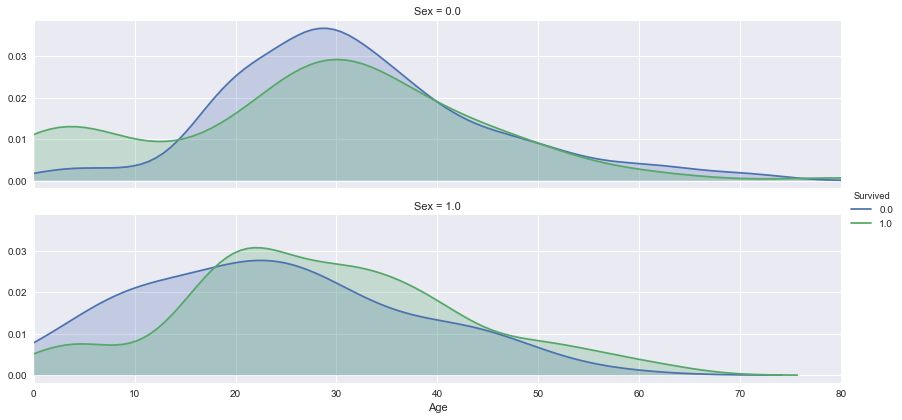

In [414]:
plot_distribution( df4 , var = 'Age' , target = 'Survived' , row = 'Sex' )

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


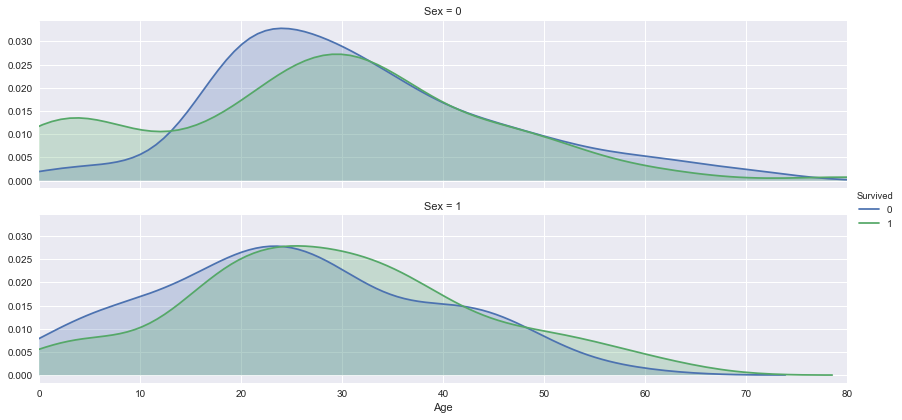

In [415]:
plot_distribution( df , var = 'Age' , target = 'Survived' , row = 'Sex' )

In [422]:
df4[df4['Age']<=0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMr,isMiss,isMrs,isMaster,isRare,Family_size,isAlone


In [460]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score